In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

import seaborn as sns
sns.set(style="ticks")


from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import describe

import matplotlib.colors as colors

from scipy import signal

from scipy.stats import probplot
from scipy.stats import normaltest

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from joblib import dump, load


In [2]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [3]:
def extract_features(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
#     amps /= 0.01
    amps = lin_log_interp(amps)
    
    _,minmax,mean,variance,skewness,kurtosis = describe(values,axis=1)
    mean = mean[...,np.newaxis]
    variance = variance[...,np.newaxis]
    skewness = skewness[...,np.newaxis]
    kurtosis = kurtosis[...,np.newaxis]
    
    sampleRMS = np.sqrt(1 / values.shape[0] * np.sum((values - np.repeat(mean,values.shape[1],axis=1).reshape(mean.shape[0],values.shape[1]))**2,axis=1))
    
    sampleRMS = sampleRMS[...,np.newaxis]
    
    print(mean.shape,variance.shape,skewness.shape,kurtosis.shape,sampleRMS.shape)
    

    stats = np.hstack((mean,variance,skewness,kurtosis,sampleRMS))
    
    return amps,stats


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

def normalize_scores(scores,log_prob=False):

    flat = np.array([])
    for i in range(len(scores)):
        flat = np.append(flat,scores[i])
    
    max_val = np.amax(flat)
    
    if log_prob:
        scores = [np.log(np.abs(scores[i] - 1.1 * max_val)) for i in range(len(scores))]
    

    norm_mean = np.mean(scores[0])
    norm_std = np.std(scores[0])
    
    scores = [(scores[i] - norm_mean) / norm_std for i in range(len(scores))]
    

    return scores

In [4]:
DoE_test = np.loadtxt('Experiment-3-Data/DoE_test_pruned.txt',delimiter=',')
DoE_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

X_train_original,stats_train_original = extract_features(X_train,)
X_test_original,stats_test_original = extract_features(X_test,)

stats_train_unhealthy = stats_train_original[first_good_train:,:]
stats_valid_unhealthy = stats_test_original[first_good_test:,:]
stats_train_healthy = stats_train_original[:first_good_train,:]
stats_valid_healthy = stats_test_original[:first_good_test,:]


X_train_unhealthy = X_train_original[first_good_train:,:]
X_valid_unhealthy = X_test_original[first_good_test:,:]
X_train_healthy = X_train_original[:first_good_train,:]
X_valid_healthy = X_test_original[:first_good_test,:]

DoE_train_healthy = DoE_train[:first_good_train,:]
DoE_train_unhealthy = DoE_train[first_good_train:,:]
DoE_test_healthy = DoE_test[:first_good_test,:]
DoE_test_unhealthy = DoE_test[first_good_test:,:]


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

Y_train = XY_train[:,-1]
Y_valid = XY_valid[:,-1]
columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']

X = []
X.append(X_train_healthy)
X.append(X_valid_healthy)
X.append(X_train_unhealthy)
X.append(X_valid_unhealthy)

DoE = []
DoE.append(DoE_train_healthy)
DoE.append(DoE_test_healthy)
DoE.append(DoE_train_unhealthy)
DoE.append(DoE_test_unhealthy)

stats = []
stats.append(stats_train_healthy)
stats.append(stats_valid_healthy)
stats.append(stats_train_unhealthy)
stats.append(stats_valid_unhealthy)
freqs = np.linspace(0,10000,2048)


(306, 1) (306, 1) (306, 1) (306, 1) (306, 1)
(151, 1) (151, 1) (151, 1) (151, 1) (151, 1)


In [5]:
np.hstack((X_train_healthy[:,:max_fft],stats_train_healthy,DoE_train_healthy[:,:DoE_shape])).shape

NameError: name 'max_fft' is not defined

In [6]:
stats_train_healthy[:,:0]

array([], shape=(156, 0), dtype=float32)

In [ ]:
max_psd = 3
max_pca = 7

means_exp = np.zeros((max_pca - 2,max_psd - 2,4))
stds_exp = np.zeros((max_pca - 2,max_psd - 2,4))
precision_recall_columns = ['Train Precision','Train Recall','Valid Precision','Valid Recall']

DoE_shape = 0
stats_shape = 5

for i in range(2,max_pca):
#     print(i)
    for j in range(2,max_psd):
        
        if max_psd < 5:
            max_fft = 0
        else:
            max_fft = j
        pca_components = i
        
        X_train = np.hstack((X_train_healthy[:,:max_fft],stats_train_healthy[:,:stats_shape],DoE_train_healthy[:,:DoE_shape]))
        
        if pca_components >= X_train.shape[1]:
#             print(X_train.shape[1])
            pca_components = X_train.shape[1] - 1
        
            

        estimators = [('reduce_dim', PCA(n_components=pca_components)), ('gmm', GaussianMixture(n_components=1))]

        pipe = Pipeline(estimators)
        pipe.fit(np.hstack((X_train_healthy[:,:max_fft],stats_train_healthy[:,:stats_shape],DoE_train_healthy[:,:DoE_shape])))

        scores = [np.zeros_like(X[i]) for i in range(len(X))]

        for k in range(len(scores)):
            scores[k] = pipe.score_samples(np.hstack((X[k][:,:max_fft],stats[k][:,:stats_shape],DoE[k][:,:DoE_shape])))
           
        norm_scores = normalize_scores(scores,log_prob=True)

        means = [np.mean(norm_scores[i]) for i in range(len(norm_scores))]
        stds = [np.std(norm_scores[i]) for i in range(len(norm_scores))]
    
        means_exp[i-2,j-2,:] = np.array(means)
        stds_exp[i-2,j-2,:] = np.array(stds)

    

In [7]:
# np.save('data/means_ND-noDoE.npy',means_exp[:128,...])
# np.save('data/stds_ND-noDoE.npy',stds_exp[:128,...])
DoE_shape = 0
means_exp = np.load('data/means_ND-noDoE.npy',allow_pickle=True)
stds_exp = np.load('data/stds_ND-noDoE.npy',allow_pickle=True)

In [8]:
max_index = 128
max_pca = 64
valid_diff = np.squeeze(means_exp[:max_index,:,0] - means_exp[:max_index,:,1])
unhealthy_diff = np.squeeze(means_exp[:max_index,:,0] - means_exp[:max_index,:,2])
unhealthy_valid_diff = np.squeeze(means_exp[:max_index,:,0] - means_exp[:max_index,:,3])
valid_std = stds_exp[:max_index,:,1]
unhealthy_std = stds_exp[:max_index,:,2]
# valid_score = np.sum(precision_recall[...,2:]**2,axis=-1)
# combined_score = (valid_score**2) + (train_score**2)

In [9]:
# Normal - valid = small positive or negative number
valid_diff.shape
# Normal - unhealthy = large positive or negative number

(126, 510)

In [10]:
def plot_scores(score):
    yi = np.arange(-0.0, score.shape[0])
    xi = np.arange(0.0,score.shape[1])

    X, Y = np.meshgrid(xi, yi)

    plt.figure(figsize=(12,4))
    ax = plt.gca()
    plt.pcolormesh(X,Y,score,cmap='cividis',norm=colors.LogNorm(vmin=np.amin(score),vmax=np.amax(score)))
    cbar = plt.colorbar()
    cbar.set_label(r'\textbf{Normalized Score}', rotation=270,labelpad=20)
    plt.ylabel(r'\textbf{PCA Dimensions}', labelpad=5,fontsize=22)
    plt.xlabel(r'\textbf{PSD Features}', labelpad=5,fontsize=22)

    plt.tight_layout(pad=1.2)

    plt.show()

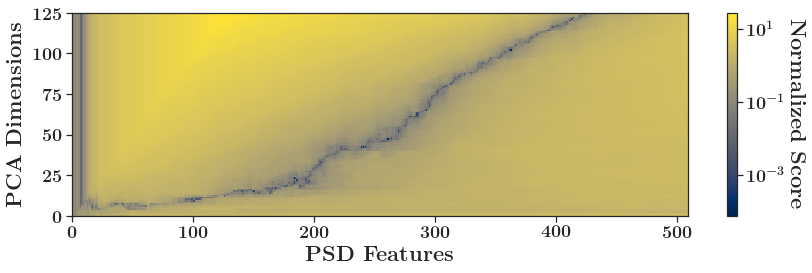

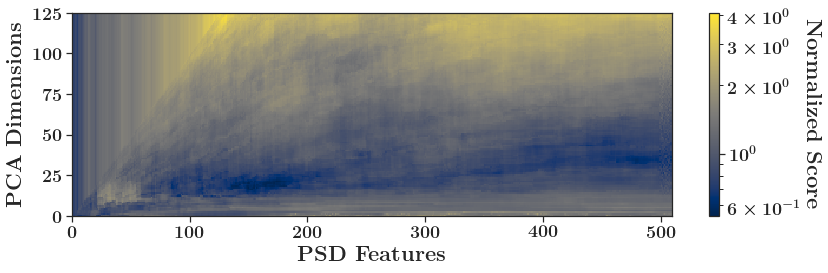

In [11]:
plot_scores(np.abs(valid_diff))
plot_scores(valid_std)

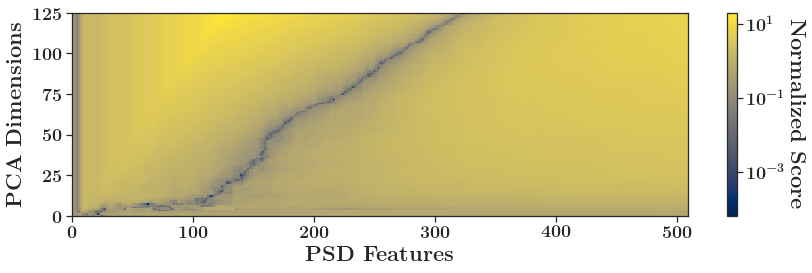

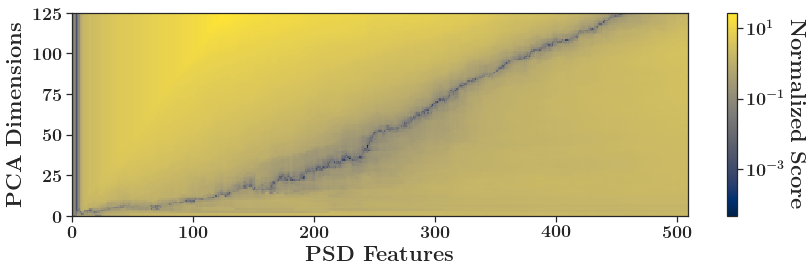

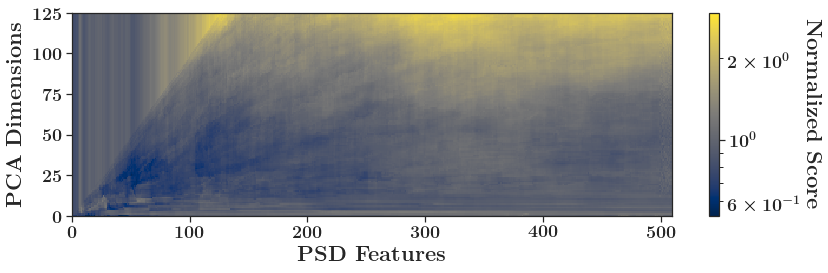

In [12]:
plot_scores(np.abs(unhealthy_diff))
plot_scores(np.abs(unhealthy_valid_diff))
plot_scores(unhealthy_std)

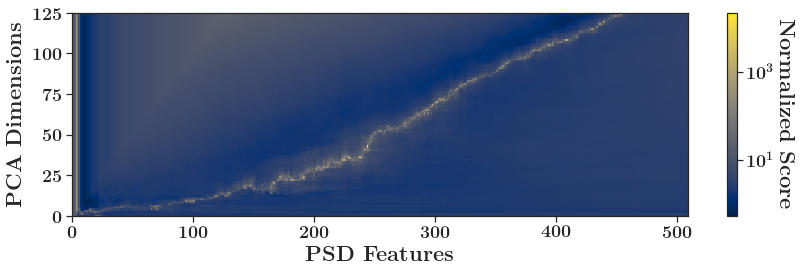

In [13]:
plot_scores(np.abs(valid_diff) + 1 / np.abs(unhealthy_valid_diff))

In [14]:
combined_score = valid_diff[:,:] - unhealthy_diff[:,:]
combined_score = 1 / np.abs(valid_diff)
combined_score = np.abs(valid_diff) + 1 / np.abs(unhealthy_valid_diff)
# combined_score = np.abs(valid_diff) - np.abs(unhealthy_diff)
# print(combined_score.flatten()[np.argmim(combined_score)])
# print(np.argmax(combined_score))
# print(np.argmax(combined_score) % combined_score.shape[1])
# print(np.argmax(combined_score) / combined_score.shape[1])

best_pca = int(np.floor(np.argmin(combined_score) / combined_score.shape[1])) + 2
best_fft = np.argmin(combined_score) % combined_score.shape[1] + 2

print(best_pca)
print(best_fft)

11
17


In [15]:
print(valid_diff)
print(unhealthy_valid_diff)

[[0.17742349 0.13609357 0.13617965 ... 2.5137552  2.52030266 2.50508532]
 [0.17742349 0.13609357 0.14792977 ... 2.61285085 2.61268531 2.60919264]
 [0.17742349 0.13609357 0.14792977 ... 1.48076132 1.48851273 1.49383075]
 ...
 [0.17742349 0.13609357 0.14792977 ... 3.28205827 3.14930407 3.1794488 ]
 [0.17742349 0.13609357 0.14792977 ... 3.2617746  3.22116478 3.23055518]
 [0.17742349 0.13609357 0.14792977 ... 3.36741881 3.21964399 3.23233425]]
[[ 0.17744953 -0.04594453 -0.0162468  ...  1.68536935  1.68590663
   1.68844643]
 [ 0.17744953 -0.04594453  0.07966146 ...  1.92009109  1.92087114
   1.92458162]
 [ 0.17744953 -0.04594453  0.07966146 ...  1.67645921  1.67930752
   1.67699466]
 ...
 [ 0.17744953 -0.04594453  0.07966146 ...  1.77804402  1.85428422
   1.92827461]
 [ 0.17744953 -0.04594453  0.07966146 ...  1.6842033   1.83451149
   1.97838253]
 [ 0.17744953 -0.04594453  0.07966146 ...  1.67797593  1.74772359
   1.80643504]]


In [16]:
print(best_fft)
print(best_pca)
print(freqs[best_fft])

17
11
83.04836345872009


In [19]:
max_fft = best_fft 
pca_components = best_pca

max_fft = 301
pca_components = 31

X_train = np.hstack((XY_train[:,:max_fft],DoE_train[:,:DoE_shape]))
X_valid = np.hstack((XY_valid[:,:max_fft],DoE_test[:,:DoE_shape]))


estimators = [('reduce_dim', PCA(n_components=pca_components)), ('gmm', GaussianMixture(n_components=2))]

pipe = Pipeline(estimators)
# pipe.fit(np.hstack((X_train_healthy[:,:max_fft],DoE_train_healthy[:,:DoE_shape])))
pipe.fit(X_train,Y_train)

scores = [np.zeros_like(X[i]) for i in range(len(X))]

for k in range(len(scores)):
    scores[k] = pipe.score_samples(np.hstack((X[k][:,:max_fft],DoE[k][:,:DoE_shape])))

norm_scores = normalize_scores(scores,log_prob=True)
[print(normaltest(norm_scores[i])) for i in range(len(norm_scores))]

NormaltestResult(statistic=50.5133342832452, pvalue=1.0744069998301395e-11)
NormaltestResult(statistic=1.5139256216697974, pvalue=0.4690889775989949)
NormaltestResult(statistic=16.570812086220883, pvalue=0.0002521702651846947)
NormaltestResult(statistic=10.659706950913561, pvalue=0.004844779839397113)


[None, None, None, None]

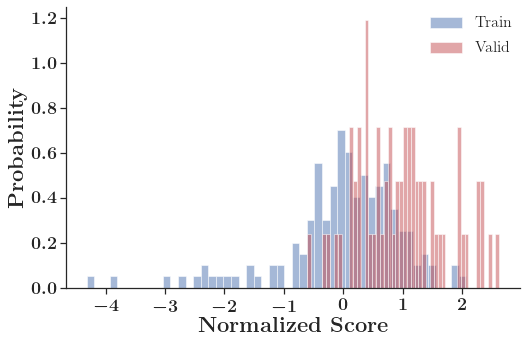

In [20]:


num_col = 1
legend_loc = 'best'
transparent=True
plt.figure(figsize=(9,6))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(norm_scores[0], 50, density=True, facecolor='b', alpha=0.50,label='Train')
n, bins, patches = plt.hist(norm_scores[1], 50, density=True, facecolor='r', alpha=0.50,label='Valid')
# n, bins, patches = plt.hist(norm_scores[2], 50, density=True, facecolor='g', alpha=0.50,label='Anomalous')
# n, bins, patches = plt.hist(norm_scores[3], 50, density=True, facecolor='c', alpha=0.50,label='Anomalous Valid')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Normalized Score}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
plt.savefig('figures/Spindle_Load_Anomalous_Compare.svg',transparent=True)     
plt.show()

# num_col = 2
# legend_loc = 'upper right'
# transparent = False

# plt.figure(figsize=(12,4))
# ax = plt.gca()
# # the histogram of the data
# n, bins, patches = plt.hist(norm_scores[0], 50, density=True, facecolor='b', alpha=0.50,label='Train')
# n, bins, patches = plt.hist(norm_scores[1], 50, density=True, facecolor='r', alpha=0.50,label='Valid')
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

# plt.xlabel(r'\textbf{Spindle Power (W)}')
# plt.ylabel(r'\textbf{Probability}')
# ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
# plt.grid(False)
# plt.savefig('figures/Spindle_Load_Anomalous_Compare.svg',transparent=True)     
# plt.show()



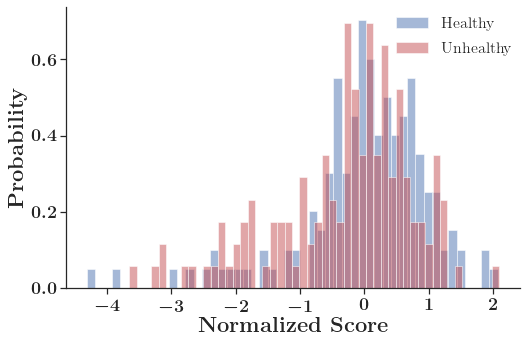

In [21]:
num_col = 1
legend_loc = 'best'
transparent=True
plt.figure(figsize=(9,6))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(norm_scores[0], 50, density=True, facecolor='b', alpha=0.50,label='Healthy')
# n, bins, patches = plt.hist(norm_scores[1], 50, density=True, facecolor='r', alpha=0.50,label='Valid')
n, bins, patches = plt.hist(norm_scores[2], 50, density=True, facecolor='r', alpha=0.50,label='Unhealthy')
# n, bins, patches = plt.hist(norm_scores[3], 50, density=True, facecolor='c', alpha=0.50,label='Anomalous Valid')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Normalized Score}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
plt.savefig('figures/Spindle_Load_Anomalous_Compare-Healthy_Unhealthy.svg',transparent=True)     
plt.show()


In [18]:
means = [np.mean(norm_scores[i]) for i in range(len(norm_scores))]
stds = [np.std(norm_scores[i]) for i in range(len(norm_scores))]


In [19]:
means

[2.50511861966702e-16,
 0.058006439906543,
 1.4736662892011592,
 1.9842146724490637]

In [20]:
[print(normaltest(norm_scores[i])) for i in range(len(norm_scores))]

NormaltestResult(statistic=4.2826434434906275, pvalue=0.11749943878052195)
NormaltestResult(statistic=2.354246052023515, pvalue=0.30816404442950857)
NormaltestResult(statistic=0.393773338040526, pvalue=0.821283704925531)
NormaltestResult(statistic=2.861282296626159, pvalue=0.23915553890794086)


[None, None, None, None]

In [21]:
z_stats

NameError: name 'z_stats' is not defined

In [22]:
# 10% two-tailed test = 1.6
# 5% two-tailed test = 1.97

z_stats = np.arange(0.1,3,0.001)

fit_statistics = np.zeros((z_stats.shape[0],4))

for i in range(z_stats.shape[0]):
    
    z_stat = z_stats[i]

    # False_positive = number of occurrences where the healthy data exceed the Z statistic threshold
    false_positive_train = norm_scores[0][norm_scores[0] > z_stat].shape[0] + norm_scores[0][norm_scores[0] < -z_stat].shape[0]
    false_positive_valid = norm_scores[1][norm_scores[1] > z_stat].shape[0] + norm_scores[1][norm_scores[1] < -z_stat].shape[0]

    # True negative = inverse of false positive
    true_negative_train = X[0].shape[0] - false_positive_train
    true_negative_valid = X[1].shape[0] - false_positive_valid

    # True positive = number of occurrences where unhealthy data exceed the Z statistic threshold
    true_positive_train = norm_scores[2][norm_scores[2] > z_stat].shape[0] + norm_scores[2][norm_scores[2] < -z_stat].shape[0]
    true_positive_valid = norm_scores[3][norm_scores[3] > z_stat].shape[0] + norm_scores[3][norm_scores[3] < -z_stat].shape[0]

    # False negative = inverse of true positive

    false_negative_train = X[2].shape[0] - true_positive_train
    false_negative_valid = X[3].shape[0] - true_positive_valid
    
    if (true_positive_train + false_positive_train) == 0:
        precision_train = 0.
    else:
        precision_train = true_positive_train / (true_positive_train + false_positive_train)
        
    if (true_positive_valid + false_positive_valid) == 0:
        precision_valid = 0.
    else:
        precision_valid = true_positive_valid / (true_positive_valid + false_positive_valid)
        
    if (true_positive_train + false_negative_train) == 0:
        recall_train = 0.
    else:
        recall_train = true_positive_train / (true_positive_train + false_negative_train)
        
    if (true_positive_valid + false_negative_valid) == 0.:
         recall_valid = 0.
    else:
        recall_valid = true_positive_valid / (true_positive_valid + false_negative_valid)
    
    fit_statistics[i,:] = np.array([precision_train,precision_valid,recall_train,recall_valid])


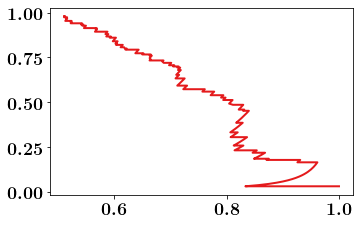

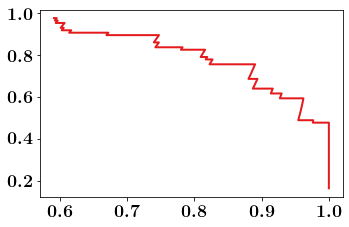

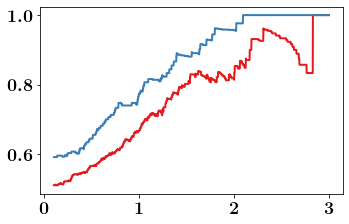

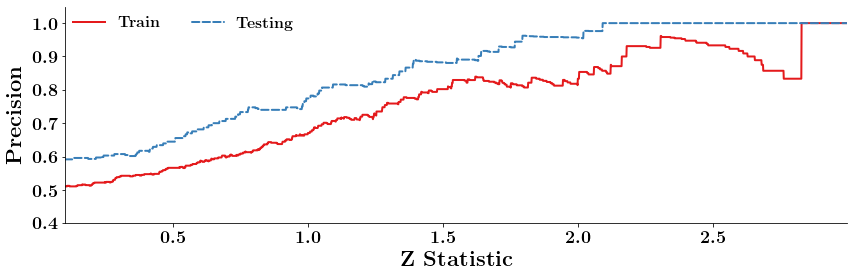

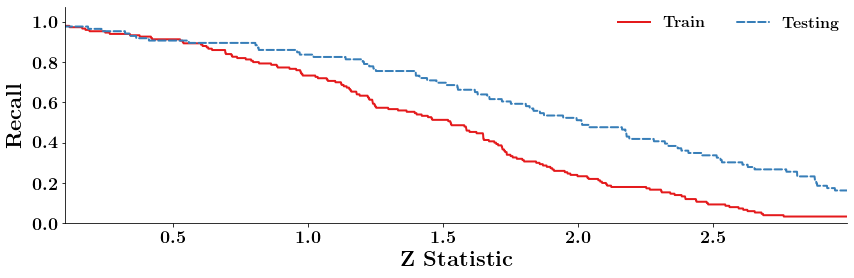

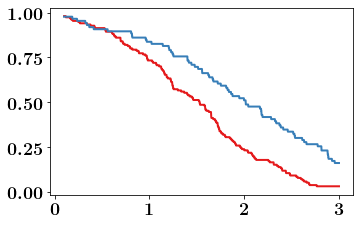

In [29]:
plt.plot(fit_statistics[:,0],fit_statistics[:,2])
plt.show()

plt.plot(fit_statistics[:,1],fit_statistics[:,3])
plt.show()

plt.plot(z_stats,fit_statistics[:,0])
plt.plot(z_stats,fit_statistics[:,1])
plt.show()

# combine the responses and labels to put on our 2D plot
responses = fit_statistics[:,:2]
labels = [r'Train','Testing']

# Create a 2D plot
genplt.generate_plot(z_stats, # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Z Statistic',# X - axis label
              'Precision',   # Y - axis label
              filename='Precision_Statistic',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     ymin=0.05,
              transparent=True,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='svg'
             )

# combine the responses and labels to put on our 2D plot
responses = fit_statistics[:,2:]
labels = [r'Train','Testing']

# Create a 2D plot
genplt.generate_plot(z_stats, # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Z Statistic',# X - axis label
              'Recall',   # Y - axis label
              filename='Recall_Statistic',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     ymin=0.05,
              transparent=True,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='svg'
             )

plt.plot(z_stats,fit_statistics[:,2])
plt.plot(z_stats,fit_statistics[:,3])
plt.show()

In [24]:
# False positive: tool is actually healthy but classified as unhealthy
# | - | X |
# | - | - |
false_positive = conf_matrix[0,1]

# False negative: tool is actually unhealthy but classified as healthy
# | - | - |
# | X | - |
false_negative = conf_matrix[1,0]

# It is better to investigate something and conclude it is healthy
# than let an unhealthy tool go unnoticed. For this reason, false
# positives are considered less costly than false negatives

# Precision: Quantifies false positives
# Recall: Quantifies false negatives

NameError: name 'conf_matrix' is not defined